In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset, Reader, accuracy, KNNBasic, SVD, NMF, SlopeOne, CoClustering, BaselineOnly
from surprise.model_selection import cross_validate

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential
from keras.layers import Dense
from sklearn import model_selection


In [2]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)

%matplotlib inline

In [3]:
df = pd.read_csv('o.csv')
df['date'] = df['event_time'].apply(lambda x: x.split()[0])
df.to_csv('initialdf.csv')
df

,event_time,event_type,product_id,category_id,category_name,brand,price,user_id,date
0,2020-11-01 17:03:26,pickup,2763,88,Детские смеси,Humana,5103,47,2020-11-01
1,2020-11-03 14:32:18,courier_delivered,21003,85,Вода питьевая и минеральная,NaN,119,447,2020-11-03
2,2020-11-05 01:04:51,pickup,5647,318,Подгузники Huggies,Kimberly Clark,1861,15,2020-11-05
3,2020-11-09 13:25:42,courier_delivered,10860,318,Подгузники Huggies,Kimberly Clark,8721,471,2020-11-09
4,2020-11-10 05:39:28,courier_delivered,8361,37,Иммуностимулирующие,World Medicine,2677,34,2020-11-10
...,...,...,...,...,...,...,...,...,...
177046,2021-05-13 01:31:07,pickup,4776,35,Средства от аллергии,Здоровье народу ХГФП,223,25838,2021-05-13
177047,2021-05-13 01:31:07,pickup,6326,35,Средства от аллергии,Химфарм АО,232,25838,2021-05-13
177048,2021-05-13 01:31:07,pickup,6613,53,Антисептики,Досфарм,916,25838,2021-05-13
177049,2021-05-13 01:46:55,pickup_issued,5521,250,Растворы для контактных линз,Avizor S.A.,2424,88,2021-05-13


In [4]:
df['user_score'] = df['event_type'].map({'pickup':1,'pickup_issued':10,'courier_delivered':50})
df['user_purchase'] = df['event_type'].apply(lambda x: 1 if x=='courier_delivered' else 0)
df['price_category'] = 0
for i in df['category_name'].unique():
    df.loc[df['category_name']==i,'price_category'] = pd.qcut(x=df['price'][df['category_name']==i],q=5,duplicates='drop')
df

,event_time,event_type,product_id,category_id,category_name,brand,price,user_id,date,user_score,user_purchase,price_category
0,2020-11-01 17:03:26,pickup,2763,88,Детские смеси,Humana,5103,47,2020-11-01,1.0,0,"(4818.0, 6817.0]"
1,2020-11-03 14:32:18,courier_delivered,21003,85,Вода питьевая и минеральная,NaN,119,447,2020-11-03,50.0,1,"(-0.001, 288.0]"
2,2020-11-05 01:04:51,pickup,5647,318,Подгузники Huggies,Kimberly Clark,1861,15,2020-11-05,1.0,0,"(1836.4, 2299.0]"
3,2020-11-09 13:25:42,courier_delivered,10860,318,Подгузники Huggies,Kimberly Clark,8721,471,2020-11-09,50.0,1,"(6952.0, 9480.0]"
4,2020-11-10 05:39:28,courier_delivered,8361,37,Иммуностимулирующие,World Medicine,2677,34,2020-11-10,50.0,1,"(2565.0, 3322.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
177046,2021-05-13 01:31:07,pickup,4776,35,Средства от аллергии,Здоровье народу ХГФП,223,25838,2021-05-13,1.0,0,"(92.999, 897.2]"
177047,2021-05-13 01:31:07,pickup,6326,35,Средства от аллергии,Химфарм АО,232,25838,2021-05-13,1.0,0,"(92.999, 897.2]"
177048,2021-05-13 01:31:07,pickup,6613,53,Антисептики,Досфарм,916,25838,2021-05-13,1.0,0,"(461.0, 11145.0]"
177049,2021-05-13 01:46:55,pickup_issued,5521,250,Растворы для контактных линз,Avizor S.A.,2424,88,2021-05-13,10.0,0,"(2129.0, 2424.0]"


In [5]:
df.to_csv('initialdf1.csv')

In [6]:
for i in df['category_name'].unique():
    df.loc[df['category_name']==i,'price_category'] = pd.qcut(x=df['price'][df['category_name']==i],q=5,duplicates='drop')

In [7]:
L = []
for i in df['price_category']:
    try:
        L.append(np.mean(i).right)
    except:
        L.append(1)
        continue;
L

[6817.0,
 288.0,
 2299.0,
 9480.0,
 3322.0,
 10035.0,
 15790.0,
 3030.0,
 3416.0,
 31215.0,
 857.2,
 13640.0,
 1474.0,
 461.0,
 461.0,
 892.0,
 2411.0,
 5576.0,
 2527.0,
 3345.2,
 990.0,
 4860.0,
 4860.0,
 1,
 14313.0,
 2774.0,
 5300.0,
 6636.0,
 51246.0,
 2734.0,
 9902.0,
 11734.0,
 20636.0,
 441.0,
 8920.0,
 1,
 2436.6,
 1,
 1004.0,
 157.0,
 590.0,
 4818.0,
 3194.0,
 19903.0,
 3940.0,
 2951.0,
 2475.0,
 1836.4,
 1135.0,
 6035.0,
 9296.0,
 13017.0,
 9296.0,
 157.0,
 62350.0,
 4604.0,
 6361.0,
 1978.0,
 1409.0,
 2475.0,
 2299.0,
 1485.0,
 152.0,
 765.0,
 660.0,
 134.0,
 11145.0,
 15370.0,
 4818.0,
 340.0,
 1316.0,
 340.0,
 1316.0,
 413.0,
 413.0,
 4818.0,
 2734.0,
 3940.0,
 380.0,
 1720.0,
 540.0,
 540.0,
 1080.0,
 1080.0,
 765.0,
 609.0,
 84.0,
 288.0,
 1646.0,
 877.0,
 280.0,
 1474.0,
 109.0,
 147.0,
 1583.0,
 21165.0,
 590.0,
 1232.0,
 882.0,
 378.0,
 970.0,
 1682.0,
 699.2,
 2475.0,
 765.0,
 13932.0,
 3260.0,
 2277.0,
 11040.0,
 2229.2,
 2005.0,
 3364.0,
 25.0,
 4818.0,
 6035.0,
 1

In [8]:
df['price_category_mean'] = L

In [9]:
group = df.groupby(['user_id','product_id'])['user_score','user_purchase'].sum().reset_index()
group['user_purchase'] = group['user_purchase'].apply(lambda x: 1 if x>1 else x)
group['user_score'] = group['user_score'].apply(lambda x: 100 if x>100 else x)

In [10]:
std = MinMaxScaler(feature_range=(0.025, 1))
std.fit(group['user_score'].values.reshape(-1,1))

group['interaction_score'] = std.transform(group['user_score'].values.reshape(-1,1))

In [11]:
group = group.merge(df[['product_id','category_name','brand','price','price_category_mean']].drop_duplicates('product_id'),on=['product_id'])

In [12]:
X_train_val, X_test = model_selection.train_test_split(group,test_size=0.2, random_state=42)

In [13]:
X_train, X_valid = model_selection.train_test_split(X_train_val,test_size=0.16, random_state=42)

In [14]:
X_valid1 = X_valid.copy()
X_valid2 = X_valid.copy()
X_train_val1 = X_train_val.copy()

In [15]:
product_cat = X_train[['product_id','price_category_mean','category_name']].drop_duplicates('product_id')
product_cat = product_cat.sort_values(by='product_id')
product_cat

,product_id,price_category_mean,category_name
54327,1,2441.0,При болезни крови
92455,2,1271.0,Детские средства для купания
48139,3,540.0,Прокладки и тампоны
100846,4,1080.0,Прокладки и тампоны
96122,5,540.0,Прокладки и тампоны
...,...,...,...
144257,28115,4380.0,Новое поступление
144481,28116,6643.8,Новое поступление
138850,28155,1.0,NaN
131436,28194,1.0,NaN


In [16]:
product_cat['price_category_mean']

54327     2441.0
92455     1271.0
48139      540.0
100846    1080.0
96122      540.0
           ...  
144257    4380.0
144481    6643.8
138850       1.0
131436       1.0
138851       1.0
Name: price_category_mean, Length: 8420, dtype: float64

In [17]:
product_cat_matrix = np.reciprocal(euclidean_distances(np.array(product_cat['price_category_mean']).reshape(-1,1))+1)

In [18]:
euclidean_matrix = pd.DataFrame(product_cat_matrix,columns=product_cat['product_id'],index=product_cat['product_id'])

In [19]:
product_cat_matrix

array([[1.00000000e+00, 8.53970965e-04, 5.25762355e-04, ...,
        4.09668169e-04, 4.09668169e-04, 4.09668169e-04],
       [8.53970965e-04, 1.00000000e+00, 1.36612022e-03, ...,
        7.86782061e-04, 7.86782061e-04, 7.86782061e-04],
       [5.25762355e-04, 1.36612022e-03, 1.00000000e+00, ...,
        1.85185185e-03, 1.85185185e-03, 1.85185185e-03],
       ...,
       [4.09668169e-04, 7.86782061e-04, 1.85185185e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.09668169e-04, 7.86782061e-04, 1.85185185e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.09668169e-04, 7.86782061e-04, 1.85185185e-03, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [20]:
euclidean_matrix

product_id,1,2,3,4,5,6,7,8,9,10,...,28070,28071,28077,28078,28079,28115,28116,28155,28194,28285
product_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000854,0.000526,0.000734,0.000526,0.000734,0.000734,0.000734,0.000526,0.000689,...,0.003268,0.000456,0.003268,0.000456,0.003268,0.000515,0.000238,0.000410,0.000410,0.000410
2,0.000854,1.000000,0.001366,0.005208,0.001366,0.005208,0.005208,0.005208,0.001366,0.003546,...,0.001155,0.000979,0.001155,0.000979,0.001155,0.000322,0.000186,0.000787,0.000787,0.000787
3,0.000526,0.001366,1.000000,0.001848,1.000000,0.001848,0.001848,0.001848,1.000000,0.002217,...,0.000626,0.003448,0.000626,0.003448,0.000626,0.000260,0.000164,0.001852,0.001852,0.001852
4,0.000734,0.005208,0.001848,1.000000,0.001848,1.000000,1.000000,1.000000,0.001848,0.010989,...,0.000946,0.001205,0.000946,0.001205,0.000946,0.000303,0.000180,0.000926,0.000926,0.000926
5,0.000526,0.001366,1.000000,0.001848,1.000000,0.001848,0.001848,0.001848,1.000000,0.002217,...,0.000626,0.003448,0.000626,0.003448,0.000626,0.000260,0.000164,0.001852,0.001852,0.001852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28115,0.000515,0.000322,0.000260,0.000303,0.000260,0.000303,0.000303,0.000303,0.000260,0.000295,...,0.000445,0.000242,0.000445,0.000242,0.000445,1.000000,0.000442,0.000228,0.000228,0.000228
28116,0.000238,0.000186,0.000164,0.000180,0.000164,0.000180,0.000180,0.000180,0.000164,0.000177,...,0.000222,0.000156,0.000222,0.000156,0.000222,0.000442,1.000000,0.000151,0.000151,0.000151
28155,0.000410,0.000787,0.001852,0.000926,0.001852,0.000926,0.000926,0.000926,0.001852,0.001010,...,0.000468,0.003984,0.000468,0.003984,0.000468,0.000228,0.000151,1.000000,1.000000,1.000000


In [23]:
tfidf_vectorizer = TfidfVectorizer()
doc_term = tfidf_vectorizer.fit_transform(list(product_cat['category_name'].values.astype('U')))
dt_matrix = pd.DataFrame(doc_term.toarray().round(3), index=[i for i in product_cat['product_id']], columns=tfidf_vectorizer.get_feature_names())

In [24]:
list(product_cat['category_name'])

['При болезни крови',
 'Детские средства для купания',
 'Прокладки и тампоны',
 'Прокладки и тампоны',
 'Прокладки и тампоны',
 'Прокладки и тампоны',
 'Прокладки и тампоны',
 'Прокладки и тампоны',
 'Прокладки и тампоны',
 'Средства по уходу за ребенком',
 'Детские средства для купания',
 'Полоскание и уход за полостью рта',
 'Детские средства для купания',
 'Прокладки и тампоны',
 'Мыло',
 'Лечение сердечно-сосудистых заболеваний',
 'Лечение алкоголизма, наркомании, табакокурения',
 'Пробиотики и пребиотики',
 'Пробиотики и пребиотики',
 'Лечение жкт',
 'Жаропонижающие',
 'Лечение жкт',
 'Противогрибковые средства',
 'Противогрибковые средства',
 'Лечение сахарного диабета',
 'Лечение артериального давления',
 'Лечение сахарного диабета',
 'Лечение сахарного диабета',
 'Лечение сахарного диабета',
 'Лечение сахарного диабета',
 'Термометры',
 'Препараты урологии и гинекологии',
 'Для кишечника',
 'Лечение жкт',
 'Лечение заболеваний опорно-двигательного аппарата',
 'Лекарственные сре

In [25]:
cos_similar_matrix = pd.DataFrame(cosine_similarity(dt_matrix.values),columns=product_cat['product_id'],index=product_cat['product_id'])

In [26]:
similar_matrix = cos_similar_matrix.multiply(euclidean_matrix)

In [27]:
X_train_matrix = pd.pivot_table(X_train,values='user_score',index='user_id',columns='product_id')
X_train_matrix = X_train_matrix.fillna(0)

In [32]:
content_matrix = X_train_matrix.dot(similar_matrix)
std = MinMaxScaler(feature_range=(0, 1))
std.fit(content_matrix.values)
content_matrix = std.transform(content_matrix.values)
content_matrix = pd.DataFrame(content_matrix,columns=sorted(X_train['product_id'].unique()),index=sorted(X_train['user_id'].unique()))
content_df = content_matrix.stack().reset_index()
content_df = content_df.rename(columns={'level_0':'user_id','level_1':'product_id',0:'predicted_interaction'})
X_valid = X_valid.merge(content_df,on=['user_id','product_id'])

In [33]:
X_valid['predicted_purchase'] = X_valid['predicted_interaction'].apply(lambda x:1 if x>=0.5 else 0)

In [34]:
item_price_precision = precision_score(X_valid['user_purchase'],X_valid['predicted_purchase'])
item_price_precision

0.8715846994535519

In [35]:
item_price_recall = recall_score(X_valid['user_purchase'],X_valid['predicted_purchase'])
item_price_recall

0.03809865042398185

In [36]:
item_price_f1 = f1_score(X_valid['user_purchase'],X_valid['predicted_purchase'])
item_price_f1

0.07300606476713582

In [37]:
content_matrix = X_train_matrix.dot(cos_similar_matrix)
std = MinMaxScaler(feature_range=(0, 1))
std.fit(content_matrix.values)
content_matrix = std.transform(content_matrix.values)
content_matrix = pd.DataFrame(content_matrix,columns=sorted(X_train['product_id'].unique()),index=sorted(X_train['user_id'].unique()))
content_df = content_matrix.stack().reset_index()
content_df = content_df.rename(columns={'level_0':'user_id','level_1':'product_id',0:'predicted_interaction'})
X_valid1 = X_valid1.merge(content_df,on=['user_id','product_id'])

In [38]:
X_valid1['predicted_purchase'] = X_valid1['predicted_interaction'].apply(lambda x:1 if x>=0.5 else 0)

In [39]:
item_precision = precision_score(X_valid1['user_purchase'],X_valid1['predicted_purchase'])
item_precision

0.8266033254156769

In [40]:
item_recall = recall_score(X_valid1['user_purchase'],X_valid1['predicted_purchase'])
item_recall

0.041562164098889284

In [41]:
item_f1 = f1_score(X_valid1['user_purchase'],X_valid1['predicted_purchase'])
item_f1

0.07914487150329771

In [42]:
product_cat = X_train[['product_id','price_category_mean','category_name','brand']].drop_duplicates('product_id')
product_cat = product_cat.sort_values(by='product_id')
product_cat

,product_id,price_category_mean,category_name,brand
54327,1,2441.0,При болезни крови,Pierre Fabre Dermo-Cosmetics
92455,2,1271.0,Детские средства для купания,Джонсон & Джонсон
48139,3,540.0,Прокладки и тампоны,Джонсон & Джонсон
100846,4,1080.0,Прокладки и тампоны,Джонсон & Джонсон
96122,5,540.0,Прокладки и тампоны,Джонсон & Джонсон
...,...,...,...,...
144257,28115,4380.0,Новое поступление,NaN
144481,28116,6643.8,Новое поступление,NaN
138850,28155,1.0,NaN,NaN
131436,28194,1.0,NaN,NaN


In [43]:
tfidf_vectorizer = TfidfVectorizer()
doc_term = tfidf_vectorizer.fit_transform(list(product_cat['brand'].values.astype('U')))
dt_matrix1 = pd.DataFrame(doc_term.toarray().round(3), index=[i for i in product_cat['product_id']], columns=tfidf_vectorizer.get_feature_names())
dt_matrix1 = dt_matrix1 + 0.01

In [44]:
cos_similar_matrix1 = pd.DataFrame(cosine_similarity(dt_matrix1.values),columns=product_cat['product_id'],index=product_cat['product_id'])

In [45]:
similar_matrix = cos_similar_matrix.multiply(euclidean_matrix).multiply(cos_similar_matrix1)

In [46]:
X_train_matrix = pd.pivot_table(X_train,values='user_score',index='user_id',columns='product_id')
X_train_matrix = X_train_matrix.fillna(0)
content_matrix = X_train_matrix.dot(similar_matrix)
std = MinMaxScaler(feature_range=(0, 1))
std.fit(content_matrix.values)
content_matrix = std.transform(content_matrix.values)
content_matrix = pd.DataFrame(content_matrix,columns=sorted(X_train['product_id'].unique()),index=sorted(X_train['user_id'].unique()))
content_df = content_matrix.stack().reset_index()
content_df = content_df.rename(columns={'level_0':'user_id','level_1':'product_id',0:'predicted_interaction'})
X_valid2 = X_valid2.merge(content_df,on=['user_id','product_id'])

In [47]:
X_valid2['predicted_purchase'] = X_valid2['predicted_interaction'].apply(lambda x:1 if x>=0.5 else 0)

In [48]:
item_price_brand_precision = precision_score(X_valid2['user_purchase'],X_valid2['predicted_purchase'])
item_price_brand_precision

0.8942307692307693

In [49]:
item_price_brand_recall = recall_score(X_valid2['user_purchase'],X_valid2['predicted_purchase'])
item_price_brand_recall

0.033321390182730205

In [50]:
item_price_brand_f1 = f1_score(X_valid2['user_purchase'],X_valid2['predicted_purchase'])
item_price_brand_f1

0.06424870466321245

In [51]:
product_cat = X_train_val1[['product_id','price_category_mean','category_name','brand']].drop_duplicates('product_id')
product_cat = product_cat.sort_values(by='product_id')
product_cat_matrix = np.reciprocal(euclidean_distances(np.array(product_cat['price_category_mean']).reshape(-1,1))+1)
euclidean_matrix = pd.DataFrame(product_cat_matrix,columns=product_cat['product_id'],index=product_cat['product_id'])

tfidf_vectorizer = TfidfVectorizer()
doc_term = tfidf_vectorizer.fit_transform(list(product_cat['category_name'].values.astype('U')))
dt_matrix = pd.DataFrame(doc_term.toarray().round(3), index=[i for i in product_cat['product_id']], columns=tfidf_vectorizer.get_feature_names())
cos_similar_matrix = pd.DataFrame(cosine_similarity(dt_matrix.values),columns=product_cat['product_id'],index=product_cat['product_id'])

tfidf_vectorizer = TfidfVectorizer()
doc_term = tfidf_vectorizer.fit_transform(list(product_cat['brand'].values.astype('U')))
dt_matrix1 = pd.DataFrame(doc_term.toarray().round(3), index=[i for i in product_cat['product_id']], columns=tfidf_vectorizer.get_feature_names())
dt_matrix1 = dt_matrix1 + 0.01
cos_similar_matrix1 = pd.DataFrame(cosine_similarity(dt_matrix1.values),columns=product_cat['product_id'],index=product_cat['product_id'])

similar_matrix = cos_similar_matrix.multiply(euclidean_matrix).multiply(cos_similar_matrix1)
X_train_val_matrix = pd.pivot_table(X_train_val1,values='user_score',index='user_id',columns='product_id')
X_train_val_matrix = X_train_val_matrix.fillna(0)

In [52]:
content_matrix = X_train_val_matrix.dot(similar_matrix)
std = MinMaxScaler(feature_range=(0, 1))
std.fit(content_matrix.values)
content_matrix = std.transform(content_matrix.values)
content_matrix = pd.DataFrame(content_matrix,columns=sorted(X_train_val1['product_id'].unique()),index=sorted(X_train_val1['user_id'].unique()))
content_df = content_matrix.stack().reset_index()
content_df = content_df.rename(columns={'level_0':'user_id','level_1':'product_id',0:'predicted_interaction'})
X_test = X_test.merge(content_df,on=['user_id','product_id'])
X_test['predicted_purchase'] = X_test['predicted_interaction'].apply(lambda x:1 if x>=0.5 else 0)

In [53]:
precision = precision_score(X_test['user_purchase'],X_test['predicted_purchase'])
precision

0.9027027027027027

In [54]:
recall = recall_score(X_test['user_purchase'],X_test['predicted_purchase'])
recall

0.037882797731568996

In [55]:
f1 = f1_score(X_test['user_purchase'],X_test['predicted_purchase'])
f1

0.07271407837445573

In [56]:
X_test.sort_values(by='interaction_score',ascending=False).head(1000)

,user_id,product_id,user_score,user_purchase,interaction_score,category_name,brand,price,price_category_mean,predicted_interaction,predicted_purchase
14945,2784,250,100.0,1,1.0,Для повышения иммунитета,Ферон ООО,1632,1674.0,3.594036e-06,0
13769,2831,13867,100.0,1,1.0,Детское пюре,Нестле,425,1316.0,3.994318e-01,0
21771,7910,10861,100.0,1,1.0,Подгузники Huggies,Kimberly Clark,8221,9480.0,3.333883e-01,0
7180,4805,159,100.0,1,1.0,Анальгетики,Ратиофарм,1216,1263.0,9.131562e-05,0
5190,5605,5314,100.0,1,1.0,Лечение заболеваний мочеполовой системы,Сервье,2044,2218.0,1.967070e-05,0
9455,10642,15907,100.0,1,1.0,Для повышения иммунитета,DEMO S.A. Pharmaceutical,2656,2666.0,0.000000e+00,0
11920,2937,3034,100.0,1,1.0,Уход за кожей ребенка,Невская косметика,775,775.0,1.720303e-01,0
14590,3402,5662,100.0,1,1.0,Подгузники Huggies,Kimberly Clark,1620,1836.4,2.052674e-03,0
24090,12053,5647,100.0,1,1.0,Подгузники Huggies,Kimberly Clark,1861,2299.0,2.085772e-05,0
23004,6035,5608,100.0,1,1.0,Подгузники Merries,Merries,8354,8354.0,1.818240e-01,0


In [57]:
sampleuser_trainval = X_train_val[X_train_val['user_id']==447]
sampleuser_trainval.to_csv('sampleuser_trainval.csv')
sampleuser_trainval

,user_id,product_id,user_score,user_purchase,interaction_score,category_name,brand,price,price_category_mean
90878,447,7769,50.0,1,0.5125,Лечение лор заболеваний,Сандоз Фармасьютикалс,5884,11040.0
27443,447,7170,50.0,1,0.5125,Лекарственные средства,Acino Pharma AG,1790,2475.0
61804,447,2523,50.0,1,0.5125,Зубные щетки,Доктор Тайсс,904,953.0
79229,447,21003,50.0,1,0.5125,Вода питьевая и минеральная,NaN,119,288.0
95969,447,22540,50.0,1,0.5125,Дермокосметика,LA ROCHE-POSAY,3814,3886.8


In [58]:
sampleuser_test = X_test[X_test['user_id']==447]
sampleuser_test.to_csv('sampleuser_test.csv')
sampleuser_test

,user_id,product_id,user_score,user_purchase,interaction_score,category_name,brand,price,price_category_mean,predicted_interaction,predicted_purchase
16430,447,194,100.0,1,1.0,Шампуни,Sebapharma GmbH&Co.KG,1942,2175.8,0.0,0


In [59]:
sample = content_df[content_df['user_id']==447].sort_values(by='predicted_interaction',ascending=False).merge(group[['product_id','category_name','brand','price','price_category_mean']].drop_duplicates('product_id'),on='product_id')
sample

,user_id,product_id,predicted_interaction,category_name,brand,price,price_category_mean
0,447,2459,0.880131,Зубные щетки,Доктор Тайсс,905,953.0
1,447,2523,0.880131,Зубные щетки,Доктор Тайсс,904,953.0
2,447,2519,0.880131,Зубные щетки,Доктор Тайсс,841,953.0
3,447,2294,0.880131,Зубные щетки,Доктор Тайсс,895,953.0
4,447,1770,0.443313,Лечение лор заболеваний,Сандоз Фармасьютикалс,2458,11040.0
...,...,...,...,...,...,...,...
8719,447,9104,0.000000,"Детские бутылочки, соски, пустышки",ARTSANA S.p.A,1927,2082.0
8720,447,9097,0.000000,"Детские бутылочки, соски, пустышки",ARTSANA S.p.A,1271,1458.0
8721,447,9095,0.000000,"Детские бутылочки, соски, пустышки",ARTSANA S.p.A,2457,3002.0
8722,447,9093,0.000000,"Детские бутылочки, соски, пустышки",ARTSANA S.p.A,1458,1458.0


In [60]:
sampleuser_recommend = sample[sample['predicted_interaction']>=0.5].sample(50,random_state=0, replace=True)
sampleuser_recommend.to_csv('sampleuser_recommend.csv')
sampleuser_recommend

,user_id,product_id,predicted_interaction,category_name,brand,price,price_category_mean
0,447,2459,0.880131,Зубные щетки,Доктор Тайсс,905,953.0
3,447,2294,0.880131,Зубные щетки,Доктор Тайсс,895,953.0
1,447,2523,0.880131,Зубные щетки,Доктор Тайсс,904,953.0
0,447,2459,0.880131,Зубные щетки,Доктор Тайсс,905,953.0
3,447,2294,0.880131,Зубные щетки,Доктор Тайсс,895,953.0
3,447,2294,0.880131,Зубные щетки,Доктор Тайсс,895,953.0
3,447,2294,0.880131,Зубные щетки,Доктор Тайсс,895,953.0
3,447,2294,0.880131,Зубные щетки,Доктор Тайсс,895,953.0
1,447,2523,0.880131,Зубные щетки,Доктор Тайсс,904,953.0
3,447,2294,0.880131,Зубные щетки,Доктор Тайсс,895,953.0


In [61]:
model = ['Item-Based','Item/Price-Based','Item/Price/Brand-Based']
scoring = ['f1','precision','recall']
model_name = ['item','item_price','item_price_brand']
model_list = []

for i in model:
    for j in scoring:
        model_dic = {'Model': i,'Scoring':j, 'Score':eval('{0}_{1}'.format(model_name[model.index(i)],j))}
        model_list.append(model_dic)

In [62]:
model_df = pd.DataFrame(model_list)
model_df

,Model,Scoring,Score
0,Item-Based,f1,0.079145
1,Item-Based,precision,0.826603
2,Item-Based,recall,0.041562
3,Item/Price-Based,f1,0.073006
4,Item/Price-Based,precision,0.871585
5,Item/Price-Based,recall,0.038099
6,Item/Price/Brand-Based,f1,0.064249
7,Item/Price/Brand-Based,precision,0.894231
8,Item/Price/Brand-Based,recall,0.033321


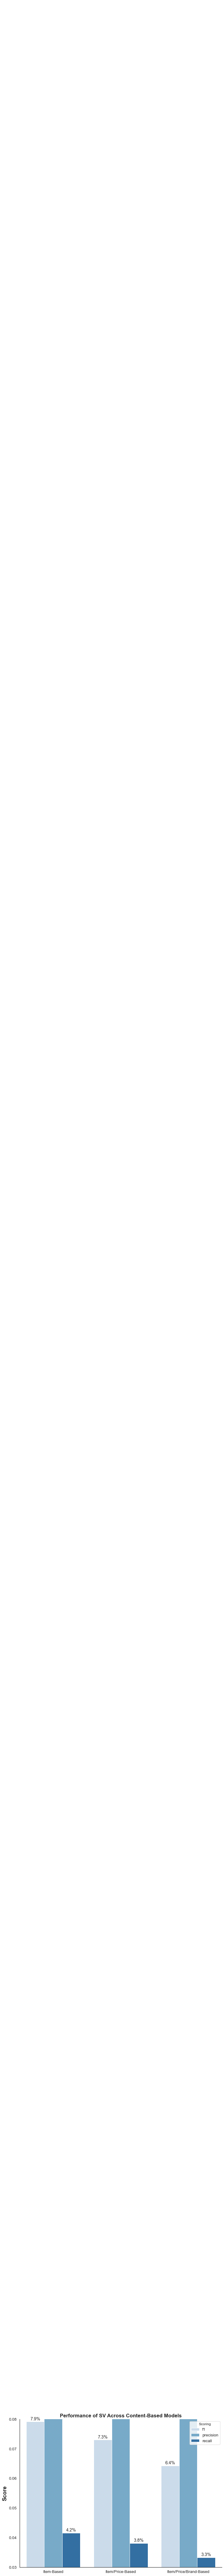

In [63]:
sns.set(style='white',font_scale=1.2)
fig = plt.figure(figsize=[12,9])
ax = sns.barplot(x='Model',y='Score',data=model_df,hue='Scoring',palette='Blues')
for p in ax.patches:
        ax.annotate(str((p.get_height()*100).round(1))+'%', (p.get_x()+0.06, p.get_height()+0.0005))
plt.ylim([0.03,0.08])      
plt.xlabel('',weight='bold',fontsize='15')
plt.ylabel('Score',weight='bold',fontsize='18')
plt.title('Performance of SV Across Content-Based Models',weight='bold',fontsize=17)
sns.despine()
plt.savefig('barplot.png',transparent=True, bbox_inches='tight')

In [64]:
user_group = group.groupby('user_id')['user_purchase'].sum()
user_group = pd.DataFrame(user_group)
user_group.sort_values(by='user_purchase')

,user_purchase
user_id,
38821,0
15523,0
15522,0
29463,0
15519,0
...,...
8080,123
7916,136
2831,183


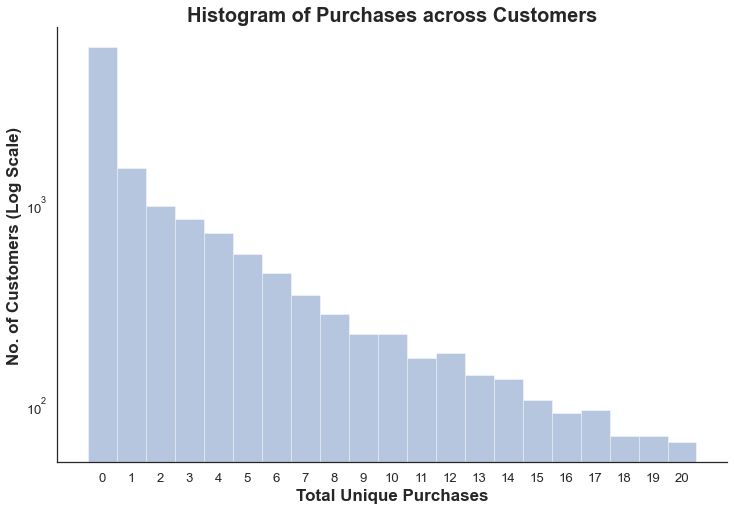

In [65]:
fig1 = plt.figure(figsize=[12,8])
ax1 = sns.distplot(user_group,bins=np.arange(22)-0.5,kde=False)
plt.yscale('log')
plt.xticks(range(0,21,1))
plt.ylabel('No. of Customers (Log Scale)',fontsize=17, weight='bold')
plt.xlabel('Total Unique Purchases', fontsize=17, weight='bold')
plt.title('Histogram of Purchases across Customers',weight='bold',fontsize=20)
sns.despine()
plt.savefig('hisplot.png',transparent=True, bbox_inches='tight')

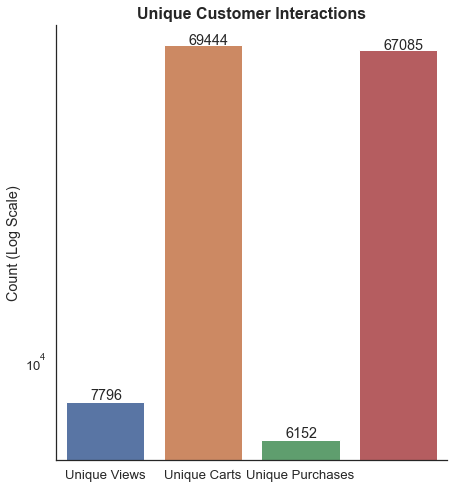

In [66]:
fig = plt.figure(figsize=[7,8])
ax = sns.countplot(df.drop_duplicates(subset=['user_id','product_id','event_type'])['event_type'])
plt.yscale('log')
for p in ax.patches:
        ax.annotate(p.get_height().round(3), (p.get_x()+0.25, p.get_height()+100))
plt.xticks(ticks=[0,1,2],labels=['Unique Views','Unique Carts','Unique Purchases'])        
plt.xlabel('')   
plt.ylabel('Count (Log Scale)')
plt.title('Unique Customer Interactions',weight='bold',fontsize=16)
sns.despine()
plt.savefig('countplot.png',transparent=True, bbox_inches='tight')

In [67]:
user_purchase = []
for i in range(1,6):
    X_sub = X_test[X_test['user_id'].isin(list(X_test.groupby('user_id')['user_purchase'].sum().reset_index()[X_test.groupby('user_id')['user_purchase'].sum().reset_index()['user_purchase']==i]['user_id']))]
    recall = recall_score(X_sub['user_purchase'],X_sub['predicted_purchase'])
    precision = precision_score(X_sub['user_purchase'],X_sub['predicted_purchase'])
    user_purchase.append({'No. of Purchase':i,'Recall':recall,'Precision':precision})

In [68]:
user_purchase = pd.DataFrame(user_purchase)
user_purchase2 = user_purchase.stack().reset_index().rename(columns={'level_0':'No. of Purchase','level_1':'Metric', 0:'Score'})[user_purchase.stack().reset_index().rename(columns={'level_0':'No. of Purchase','level_1':'Metric', 0:'Score'})['Metric']!='No. of Purchase']
user_purchase2['No. of Purchase'] = user_purchase2['No. of Purchase'].apply(lambda x:x+1)
user_purchase2

,No. of Purchase,Metric,Score
1,1,Recall,0.008381
2,1,Precision,0.800000
4,2,Recall,0.016008
5,2,Precision,0.850000
7,3,Recall,0.028756
8,3,Precision,0.924528
10,4,Recall,0.031944
11,4,Precision,0.920000
13,5,Recall,0.023963
14,5,Precision,0.962963


In [69]:
user_purchase.stack().reset_index()

,level_0,level_1,0
0,0,No. of Purchase,1.000000
1,0,Recall,0.008381
2,0,Precision,0.800000
3,1,No. of Purchase,2.000000
4,1,Recall,0.016008
5,1,Precision,0.850000
6,2,No. of Purchase,3.000000
7,2,Recall,0.028756
8,2,Precision,0.924528
9,3,No. of Purchase,4.000000


In [70]:
user_group = X_test.groupby('user_id')['user_purchase'].sum()
user_group = pd.DataFrame(user_group)
user_group.sort_values(by='user_purchase')

,user_purchase
user_id,
38821,0
32413,0
13306,0
32401,0
13325,0
...,...
17921,24
4510,28
2831,33


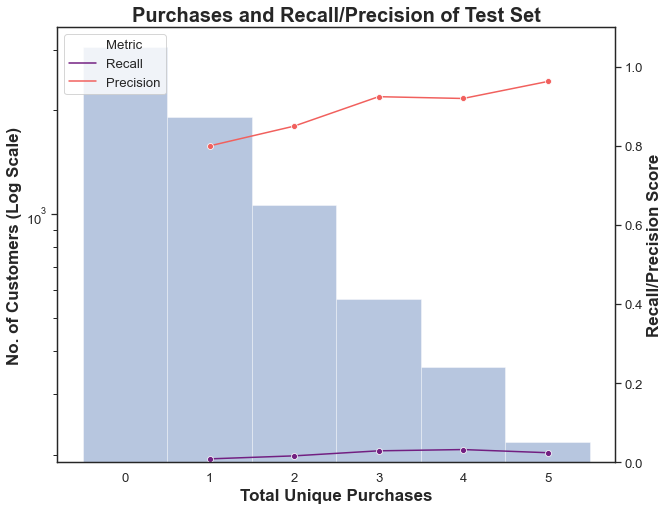

In [71]:

fig1 = plt.figure(figsize=[10,8])
ax1 = sns.distplot(user_group,bins=np.arange(7)-0.5,kde=False)
plt.yscale('log')
plt.xticks(range(0,6,1))
plt.ylabel('No. of Customers (Log Scale)',fontsize=17, weight='bold')
plt.xlabel('Total Unique Purchases', fontsize=17, weight='bold')
ax2 = plt.twinx()
sns.lineplot(x='No. of Purchase',y='Score',data=user_purchase2, hue='Metric',ax=ax2,marker='o',sort=False,palette='magma')
plt.ylim([0,1.1])
plt.ylabel('Recall/Precision Score',fontsize=17,weight='bold') 
plt.title('Purchases and Recall/Precision of Test Set',weight='bold',fontsize=20)
plt.savefig('mixplot.png',transparent=True, bbox_inches='tight')

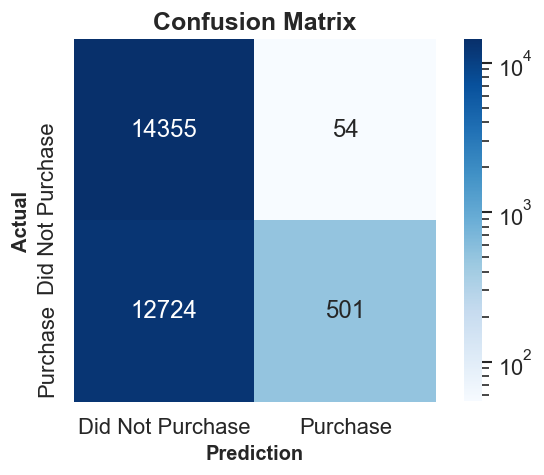

In [72]:
from matplotlib.colors import LogNorm
satisfaction_confusion = confusion_matrix(X_test['user_purchase'], X_test['predicted_purchase'])
plt.figure(dpi=120)
ax = sns.heatmap(satisfaction_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',norm=LogNorm(),
xticklabels=['Did Not Purchase', 'Purchase'],
yticklabels=['Did Not Purchase', 'Purchase']);   
plt.xlabel('Prediction',weight='bold',fontsize=12)
plt.ylabel('Actual',weight='bold',fontsize=12)
plt.title('Confusion Matrix',weight='bold',fontsize=15)
plt.savefig('confusionmatrix.png',transparent=True, bbox_inches='tight')

In [73]:
group.to_csv('groupdf.csv')